In [2]:
import os
import pandas as pd
import numpy as np
import datetime
import json
import matplotlib.pyplot as plt

In [21]:
os.listdir("/tmp/pvc/data/")

['kepler_node_dram_joules_total_data_20241003-123232.csv',
 'kepler_node_other_joules_total_data_20241003-123333.csv',
 'kepler_node_package_joules_total_data_20241003-123434.csv',
 'kepler_node_platform_joules_total_data_20241003-123534.csv',
 'node_cpu_seconds_total_data_20241003-123724.csv']

In [23]:
directory="/tmp/pvc/data/"
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]
dataframes = []
metrics_file_map = {}

# Load each CSV file and append to the list
for csv_file in csv_files:
    file_path=""
    if "node_cpu_seconds" in csv_file:
        file_path = os.path.join(directory, csv_file)
        metrics_file_map.update({"cpu_util":file_path})
    elif "kepler_node_package_joules_total" in csv_file:
        file_path = os.path.join(directory, csv_file)
        metrics_file_map.update({"node_package_power":file_path})
    elif "kepler_node_dram_joules_total" in csv_file:
        file_path = os.path.join(directory, csv_file)
        metrics_file_map.update({"node_dram_power":file_path})

print(f"Metric files{metrics_file_map}")
print(f"Size: {len(metrics_file_map)}")

Metric files{'node_dram_power': '/tmp/pvc/data/kepler_node_dram_joules_total_data_20241003-123232.csv', 'node_package_power': '/tmp/pvc/data/kepler_node_package_joules_total_data_20241003-123434.csv', 'cpu_util': '/tmp/pvc/data/node_cpu_seconds_total_data_20241003-123724.csv'}
Size: 3


In [24]:
cpu_util = pd.read_csv(metrics_file_map.get("cpu_util"))
cpu_util = cpu_util[cpu_util['mode']!='idle']
cpu_util_agg = cpu_util.groupby(['instance', 'timestamp'], as_index=False)['value'].sum()
cpu_util_agg['timestamp'] = pd.to_datetime(cpu_util_agg['timestamp'])

print(f"cpu_util_agg {cpu_util_agg}")

node_package_power = pd.read_csv(metrics_file_map.get("node_package_power"))
node_package_power = node_package_power.groupby(['instance', 'timestamp'], as_index=False)['value'].sum()
node_package_power['timestamp'] = pd.to_datetime(node_package_power['timestamp'])

print(f"node_package_power {node_package_power}")



cpu_util_agg             instance                     timestamp      value
0     kube-master-90 1970-01-01 00:00:01.727870700  516368.68
1     kube-master-90 1970-01-01 00:00:01.727870760  516442.20
2     kube-master-90 1970-01-01 00:00:01.727870820  516476.56
3     kube-master-90 1970-01-01 00:00:01.727870880  516544.81
4     kube-master-90 1970-01-01 00:00:01.727870940  516589.22
...              ...                           ...        ...
3945  kube-worker-68 1970-01-01 00:00:01.727949360  446666.12
3946  kube-worker-68 1970-01-01 00:00:01.727949420  446759.39
3947  kube-worker-68 1970-01-01 00:00:01.727949480  446846.52
3948  kube-worker-68 1970-01-01 00:00:01.727949540  446953.72
3949  kube-worker-68 1970-01-01 00:00:01.727949600  447057.98

[3950 rows x 3 columns]
node_package_power             instance                     timestamp        value
0     kube-master-90 1970-01-01 00:00:01.727870880     1039.496
1     kube-master-90 1970-01-01 00:00:01.727870940     6254.979
2     k

In [25]:
print(cpu_util_agg['instance'].unique())
print(node_package_power['instance'].unique())

['kube-master-90' 'kube-worker-171' 'kube-worker-68']
['kube-master-90' 'kube-worker-171' 'kube-worker-68']


In [28]:
node_dram_power = pd.read_csv(metrics_file_map.get("node_dram_power"))
node_dram_power = node_dram_power.groupby(['instance', 'timestamp'], as_index=False)['value'].sum()
node_dram_power['timestamp'] = pd.to_datetime(node_dram_power['timestamp'])

print(node_dram_power['instance'].unique())

node_power_metrics = pd.merge(node_package_power, node_dram_power, on = ["timestamp", "instance"])
node_power_metrics = node_power_metrics.rename(columns={"value_x":"package", "value_y":"dram"})
node_power_metrics['power'] = node_power_metrics['package'] + node_power_metrics['dram']

print(f"node_power_metrics {node_power_metrics}")

['kube-master-90' 'kube-worker-171' 'kube-worker-68']
node_power_metrics             instance                     timestamp      package         dram  \
0     kube-master-90 1970-01-01 00:00:01.727870880     1039.496     1032.973   
1     kube-master-90 1970-01-01 00:00:01.727870940     6254.979     6237.846   
2     kube-master-90 1970-01-01 00:00:01.727871000    11445.914    11418.658   
3     kube-master-90 1970-01-01 00:00:01.727871060    16743.126    16684.088   
4     kube-master-90 1970-01-01 00:00:01.727871120    22031.810    21911.234   
...              ...                           ...          ...          ...   
3933  kube-worker-68 1970-01-01 00:00:01.727949360  5656913.538  5716869.148   
3934  kube-worker-68 1970-01-01 00:00:01.727949420  5661246.870  5721214.257   
3935  kube-worker-68 1970-01-01 00:00:01.727949480  5665558.852  5725650.483   
3936  kube-worker-68 1970-01-01 00:00:01.727949540  5669943.004  5730051.889   
3937  kube-worker-68 1970-01-01 00:00:01.727949

In [29]:
print(node_power_metrics['instance'].unique())


['kube-master-90' 'kube-worker-171' 'kube-worker-68']


In [7]:
print(node_power_metrics)

            instance                     timestamp     package        dram  \
0    kube-worker-171 1970-01-01 00:00:01.727094720       0.000       0.000   
1    kube-worker-171 1970-01-01 00:00:01.727094780    3835.227    3015.508   
2    kube-worker-171 1970-01-01 00:00:01.727094840    7654.595    6014.893   
3    kube-worker-171 1970-01-01 00:00:01.727094900   11462.017    9010.162   
4    kube-worker-171 1970-01-01 00:00:01.727094960   15273.291   11992.979   
..               ...                           ...         ...         ...   
120  kube-worker-171 1970-01-01 00:00:01.727101920  472479.596  375665.950   
121  kube-worker-171 1970-01-01 00:00:01.727101980  476452.041  378819.640   
122  kube-worker-171 1970-01-01 00:00:01.727102040  480418.549  381956.470   
123  kube-worker-171 1970-01-01 00:00:01.727102100  484413.754  385150.324   
124  kube-worker-171 1970-01-01 00:00:01.727102160  488378.047  388314.636   

          power  
0         0.000  
1      6850.735  
2     136

In [15]:
node_power_metrics.to_csv("node_power_metrics_df.csv")
cpu_util_agg.to_csv("cpu_util_agg_df.csv")

Text(0.5, 1.0, 'Energy(J) vs Utilisation')

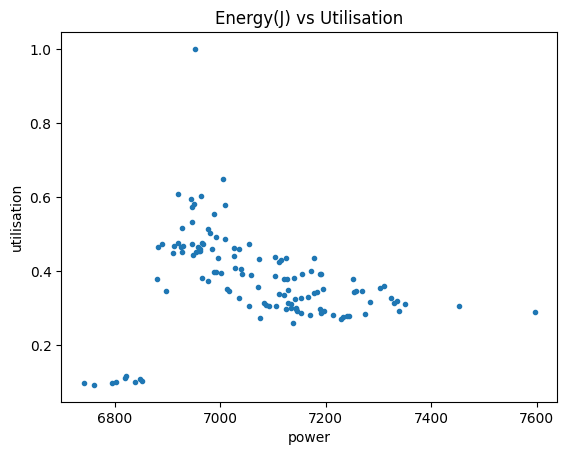

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

power = pd.read_csv("node_power_metrics_df.csv")
util = pd.read_csv("cpu_util_agg_df.csv")

merged_df = pd.merge(util, power, on=['timestamp', 'instance'])
merged_df['util'] = merged_df['value'].diff()
merged_df['power_used'] = merged_df['power'].diff()
merged_df = merged_df.dropna()
merged_df['util'] = merged_df['util'] / max(merged_df['util'])

plt.plot(merged_df['power_used'], merged_df['util'], '.')
plt.xlabel("power")
plt.ylabel("utilisation")
plt.title("Energy(J) vs Utilisation")



In [9]:
import model

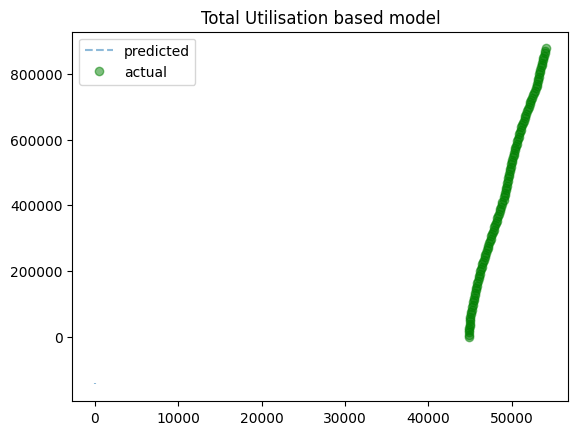

In [32]:
# Step 1: Merge the DataFrames on 'instance' and 'timestamp'
merged_df = pd.merge(util, power, on=['instance', 'timestamp'])

# Step 2: Calculate total power if it's not already in node_power_metrics
merged_df['power'] = merged_df['package'] + merged_df['dram']

# Step 3: Prepare the data for the model
# We need a DataFrame with 'util' and 'power' columns
training_data = merged_df[['value', 'power']].copy()
training_data.columns = ['util', 'power']  # Renaming for compatibility with the model

# Step 4: Initialize the model
m = model.UtilisationPowerModel()

# Step 5: Train the model
# You can specify learning rate and epochs as needed
result = m.get_model(training_data, learning_rate=0.00002, epochs=10000)

# The result will include predicted values, the loss history, and the model parameters


['kube-master-90' 'kube-worker-171' 'kube-worker-68']
['kube-master-90' 'kube-worker-171' 'kube-worker-68']
Node :  kube-master-90
          instance_x                     timestamp       util      instance_y  \
0     kube-master-90 1970-01-01 00:00:01.727870700  516368.68             NaN   
1     kube-master-90 1970-01-01 00:00:01.727870760  516442.20             NaN   
2     kube-master-90 1970-01-01 00:00:01.727870820  516476.56             NaN   
3     kube-master-90 1970-01-01 00:00:01.727870880  516544.81  kube-master-90   
4     kube-master-90 1970-01-01 00:00:01.727870940  516589.22  kube-master-90   
...              ...                           ...        ...             ...   
1311  kube-master-90 1970-01-01 00:00:01.727949360  645287.28  kube-master-90   
1312  kube-master-90 1970-01-01 00:00:01.727949420  645374.64  kube-master-90   
1313  kube-master-90 1970-01-01 00:00:01.727949480  645463.48  kube-master-90   
1314  kube-master-90 1970-01-01 00:00:01.727949540  645556.

/tmp/ipykernel_3021025/3983092213.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  node_df['power'].fillna(node_df['power'].mean(), inplace=True)


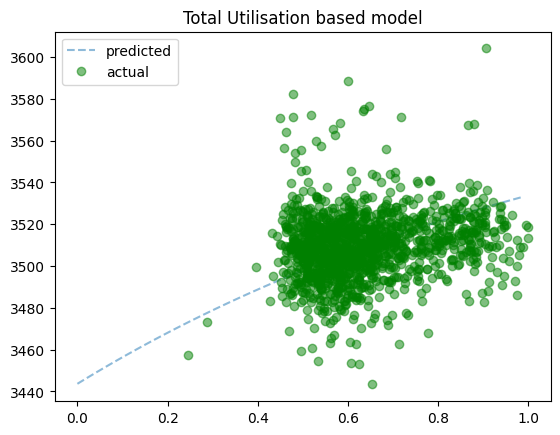

Node :  kube-worker-171
           instance_x                     timestamp       util  \
0     kube-worker-171 1970-01-01 00:00:01.727870640  321856.41   
1     kube-worker-171 1970-01-01 00:00:01.727870700  321877.97   
2     kube-worker-171 1970-01-01 00:00:01.727870760  321897.01   
3     kube-worker-171 1970-01-01 00:00:01.727870820  321916.18   
4     kube-worker-171 1970-01-01 00:00:01.727870880  321968.49   
...               ...                           ...        ...   
1312  kube-worker-171 1970-01-01 00:00:01.727949360  430910.84   
1313  kube-worker-171 1970-01-01 00:00:01.727949420  430982.47   
1314  kube-worker-171 1970-01-01 00:00:01.727949480  431079.51   
1315  kube-worker-171 1970-01-01 00:00:01.727949540  431176.28   
1316  kube-worker-171 1970-01-01 00:00:01.727949600  431258.57   

           instance_y      package         dram        power  
0                 NaN          NaN          NaN          NaN  
1                 NaN          NaN          NaN          

/tmp/ipykernel_3021025/3983092213.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  node_df['power'].fillna(node_df['power'].mean(), inplace=True)


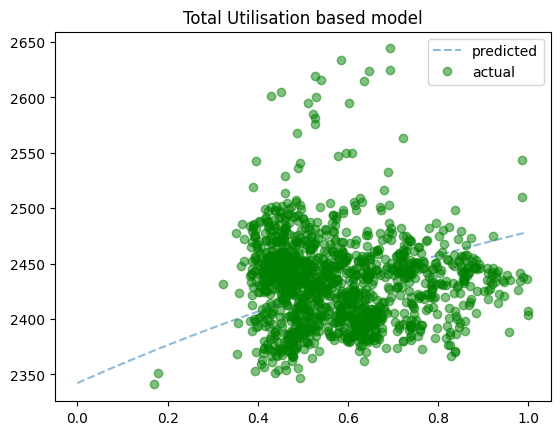

Node :  kube-worker-68
          instance_x                     timestamp       util      instance_y  \
0     kube-worker-68 1970-01-01 00:00:01.727870640  341841.91             NaN   
1     kube-worker-68 1970-01-01 00:00:01.727870700  341860.70             NaN   
2     kube-worker-68 1970-01-01 00:00:01.727870760  341878.77             NaN   
3     kube-worker-68 1970-01-01 00:00:01.727870820  341896.80             NaN   
4     kube-worker-68 1970-01-01 00:00:01.727870880  341946.52             NaN   
...              ...                           ...        ...             ...   
1312  kube-worker-68 1970-01-01 00:00:01.727949360  446666.12  kube-worker-68   
1313  kube-worker-68 1970-01-01 00:00:01.727949420  446759.39  kube-worker-68   
1314  kube-worker-68 1970-01-01 00:00:01.727949480  446846.52  kube-worker-68   
1315  kube-worker-68 1970-01-01 00:00:01.727949540  446953.72  kube-worker-68   
1316  kube-worker-68 1970-01-01 00:00:01.727949600  447057.98  kube-worker-68   

    

/tmp/ipykernel_3021025/3983092213.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  node_df['power'].fillna(node_df['power'].mean(), inplace=True)


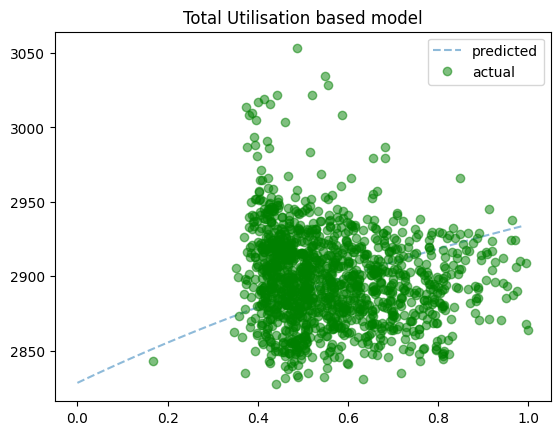

In [34]:
node_power_models = {}
print(cpu_util_agg['instance'].unique())
print(node_power_metrics['instance'].unique())

for node in cpu_util_agg['instance'].unique():
    print("Node : ", node)
    cpu = cpu_util_agg[cpu_util_agg['instance']==node]
    power = node_power_metrics[node_power_metrics['instance']==node]
    data = pd.merge_asof(cpu, power, on = 'timestamp')
    data.rename(columns={'value':'util'}, inplace=True)
    data.sort_values('timestamp', inplace=True)
    print(data)
    node_df = data
    print(node_df)
    print(f" Node {node} : {node_df[['util','timestamp']]} ")
    m = model.UtilisationPowerModel()
    
    
    node_df['util'] = node_df['util'].diff()
    node_df['energy'] = node_df['power'].diff()
    node_df.fillna(0, inplace=True)

#     node_df = node_df.iloc[500: , :]

    node_df = node_df[(node_df[['util']] != 0).all(axis=1)]
    node_df = node_df[(node_df[['energy']] != 0).all(axis=1)]
    max_util = max(node_df['util'])
    node_df['util'] = node_df['util']/max_util

    node_df['power'] = node_df['energy']/3
    node_df['power'].fillna(node_df['power'].mean(), inplace=True)
    node_power_models[node] = m.get_model(node_df[['util', 'power']])

In [39]:
for node in node_power_models:
    print(node_power_models[node][2])


(tensor(3604.0291, requires_grad=True), tensor(-160.3541, requires_grad=True), tensor(-0.8253, requires_grad=True))
(tensor(2644.0950, requires_grad=True), tensor(-301.8981, requires_grad=True), tensor(-0.6013, requires_grad=True))
(tensor(3053.0566, requires_grad=True), tensor(-224.7781, requires_grad=True), tensor(-0.6411, requires_grad=True))
